## import

In [29]:
from src.config.config import Config
from src.db_writer.db import DB
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12.8, 7.2)

## load data

### load from binance

In [31]:
# config = Config()
# db = DB(config)

In [32]:
from src.quarter_functions import get_delivery, get_quarter_time_left, get_quarter_symbol

In [33]:
# BTC_perp_bid_ask['timestamp'].min(), BTC_perp_bid_ask['timestamp'].max()
# (1661248680, 1684138560)

In [34]:
# def preprocess_data(data, symbol):
#     data_preprocessed = pd.DataFrame([[row[i] for i in [0,1,4,3,2,5,8]] for row in data], 
#                 columns=['timestamp', 'open', 'close', 'low', 'high', 'volume', 'trades'])
#     data_preprocessed['timestamp']/=1000
#     data_preprocessed.insert(column='symbol', loc=1, value=symbol)
#     return data_preprocessed


In [35]:
# def load_historical_perentrentual_data_batches(num_batches=1000):
#     all_time_data = []
#     endTime = (1684138560 + 30) * 1000
#     while endTime > 1661248680 * 1000:
#         all_time_data += config.binance_client.futures_klines(
#                     symbol = config.symbol, 
#                     interval = '1m', 
#                     limit = 1500, 
#                     endTime = endTime)
#         endTime -= 90000000
#     return preprocess_data(all_time_data, 'BTCUSDT')        


# def load_historical_quarterly_data_batches( num_batches=120):
#     final_data = pd.DataFrame()
#     endTime = (1684138560 + 30) * 1000
#     symbol = get_quarter_symbol(config.symbol,endTime/1000)
#     finished_trigger = False
#     quarter_data = []
#     while endTime > 1661248680 * 1000:
#         for i in range(num_batches):
#             data_1500 = config.binance_client.futures_klines(
#                             symbol = symbol, 
#                             interval = '1m', 
#                             limit = 1500, 
#                             endTime = endTime)
#             quarter_data += data_1500
#             endTime -= 90000000
            
#             if(len(data_1500) < 1500):
#                 finished_trigger = True
#                 break

#         if(finished_trigger == True):
#             final_data = pd.concat([final_data, preprocess_data(quarter_data, symbol)])
#             quarter_data = []
#             print(f"quarter {symbol} loading finished successfully")
#             symbol = get_quarter_symbol(config.symbol,endTime//1000)
#             endTime = get_delivery(endTime//1000)*1000
#             # print(f"{symbol} quarter endTime is {endTime}")
#             finished_trigger = False
#             print(f"quarter {symbol} loading")
#         else:
#             final_data = pd.concat([final_data, preprocess_data(quarter_data, symbol)])
#             print(symbol, end=' ')   
#     print(symbol)
#     return final_data 

In [36]:
# load_historical_perentrentual_data_batches().to_csv('data/load_historical_perentrentual_data_batches.csv')

In [37]:
# load_historical_quarterly_data_batches().to_csv('data/load_historical_quarterly_data_batches.csv')

### load rest

In [38]:
# BTC_current_quarter = pd.read_sql('SELECT * FROM `exchange data`.BTC_current_quarter;', con=db.con)
# BTC_current_quarter.to_csv('BTC_current_quarter.csv')

# BTC_perpetual = pd.read_sql('SELECT * FROM `exchange data`.BTC_perpetual;', con=db.con)
# BTC_perpetual.to_csv('BTC_perpetual.csv')

# BTC_cq_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_cq_bid_ask;', con=db.con)
# BTC_cq_bid_ask.to_csv('data/BTC_cq_bid_ask.csv')

# BTC_perp_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_perp_bid_ask;', con=db.con)
# BTC_perp_bid_ask.to_csv('data/BTC_perp_bid_ask.csv')

In [39]:
BTC_current_quarter = pd.read_csv('data/load_historical_quarterly_data_batches.csv', index_col=[0])
# BTC_current_quarter = pd.read_csv('data/BTC_current_quarter.csv', index_col=[0])
BTC_perpetual = pd.read_csv('data/load_historical_perentrentual_data_batches.csv', index_col=[0])
# BTC_perpetual = pd.read_csv('data/BTC_perpetual.csv', index_col=[0])
BTC_cq_bid_ask = pd.read_csv('data/BTC_cq_bid_ask.csv', index_col=[0])
BTC_perp_bid_ask = pd.read_csv('data/BTC_perp_bid_ask.csv', index_col=[0])

In [40]:
BTC_current_quarter = BTC_current_quarter\
            .sort_values(['timestamp', 'symbol'])\
            .drop_duplicates(subset=['timestamp'], keep='first')\
            .reset_index(drop=True)

BTC_perpetual.sort_values('timestamp', inplace=True)

## merge

In [41]:
candles = BTC_perpetual.merge(
            BTC_current_quarter, 
            on='timestamp', 
            how='left', 
            suffixes=['_perp', '_cq'])

In [42]:
order_book = BTC_perp_bid_ask.merge(
            BTC_cq_bid_ask, 
            on='timestamp', 
            suffixes=['_perp', '_cq'])

In [43]:
candles = candles[candles['timestamp'] >= order_book['timestamp'].min()]

In [44]:
df_total = candles.merge(
            order_book, 
            on='timestamp',
            how='left')

In [45]:
# df_total = BTC_perpetual.merge(
#                 BTC_perp_bid_ask.drop('funding_rate', axis=1), on='timestamp')\
#         .merge(
#         BTC_current_quarter.merge(
#                 BTC_cq_bid_ask.drop('time_left', axis=1), on='timestamp'),
#         on = 'timestamp',
#         suffixes=['_perp', '_cq']
#         )

In [46]:
df_total['timestamp'] = df_total['timestamp'].astype(int)
df_total['time_left'] = df_total['timestamp'].apply(get_quarter_time_left)

In [47]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


### Funding rate restoration

## Fill missing

In [48]:
df_total = df_total.interpolate()

## EDA

In [49]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


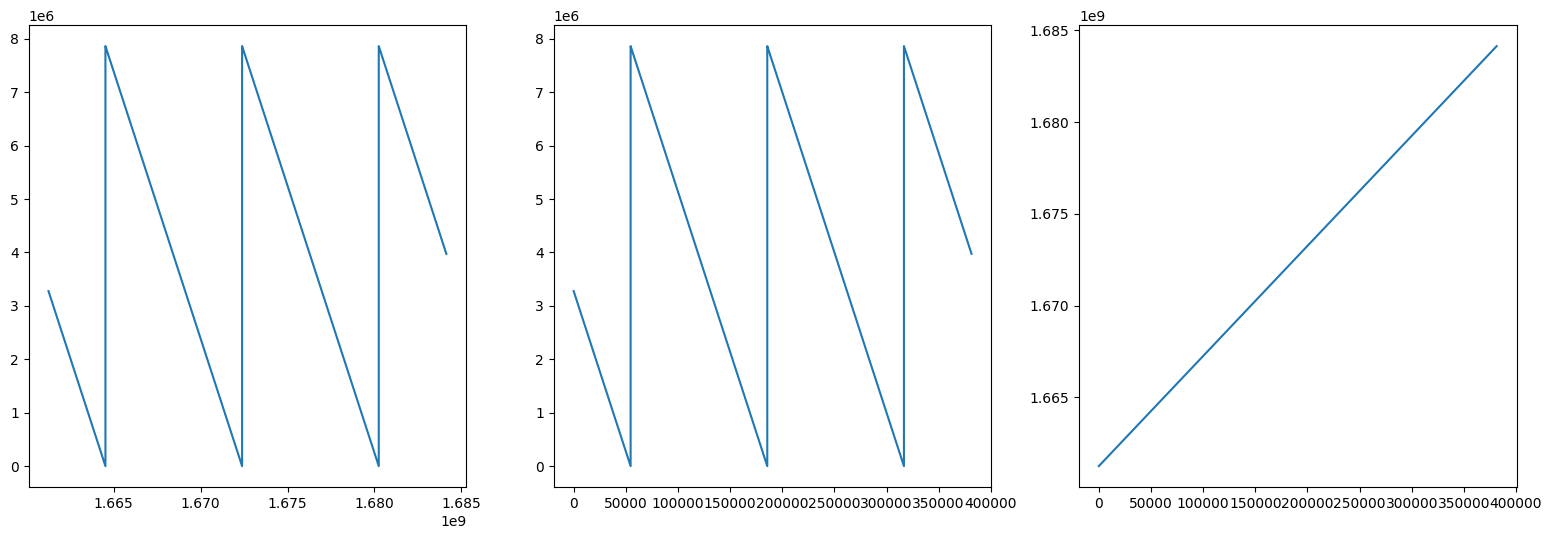

In [50]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(19.2, 6))
ax1.plot(df_total['timestamp'], df_total['time_left'])
ax2.plot(df_total['time_left'])
ax3.plot(df_total['timestamp'])
plt.show()

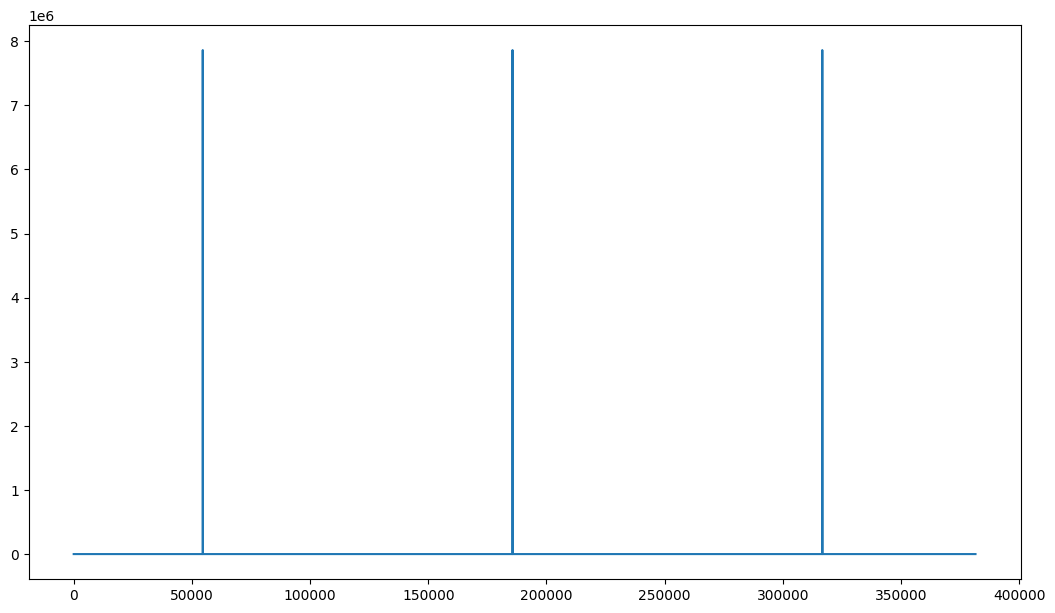

In [51]:
plt.figure(figsize=(12.8, 7.2))
temp = df_total['time_left'].diff()
plt.plot(temp)

(0.0, 32000.0)

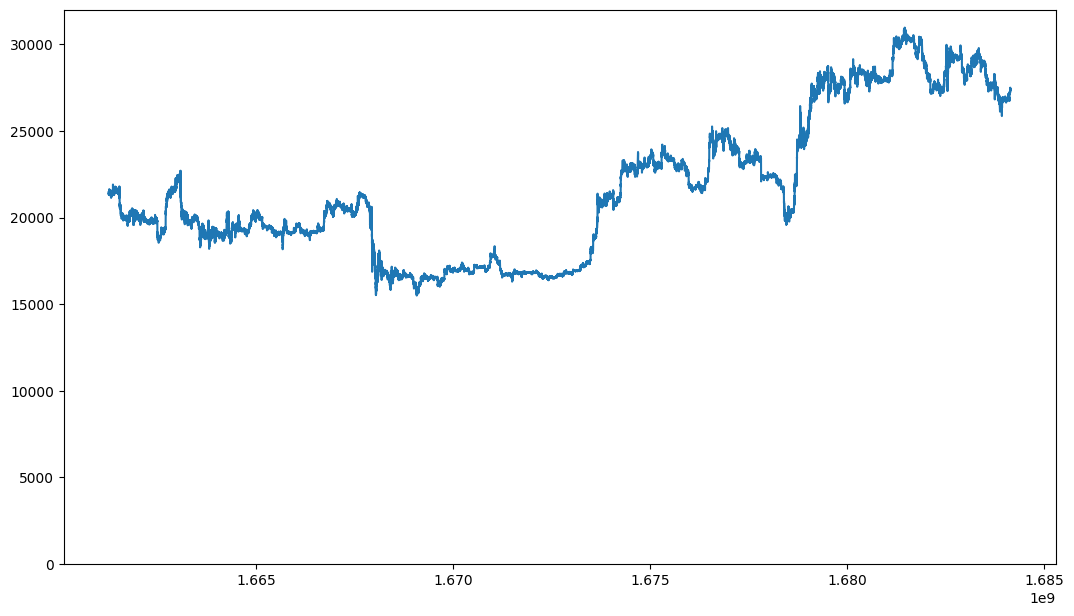

In [52]:
plt.figure(figsize = (12.8, 7.2))
plt.plot(df_total['timestamp'], df_total['open_perp'])
plt.ylim([0, 32000])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_cq'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])

### other features overview

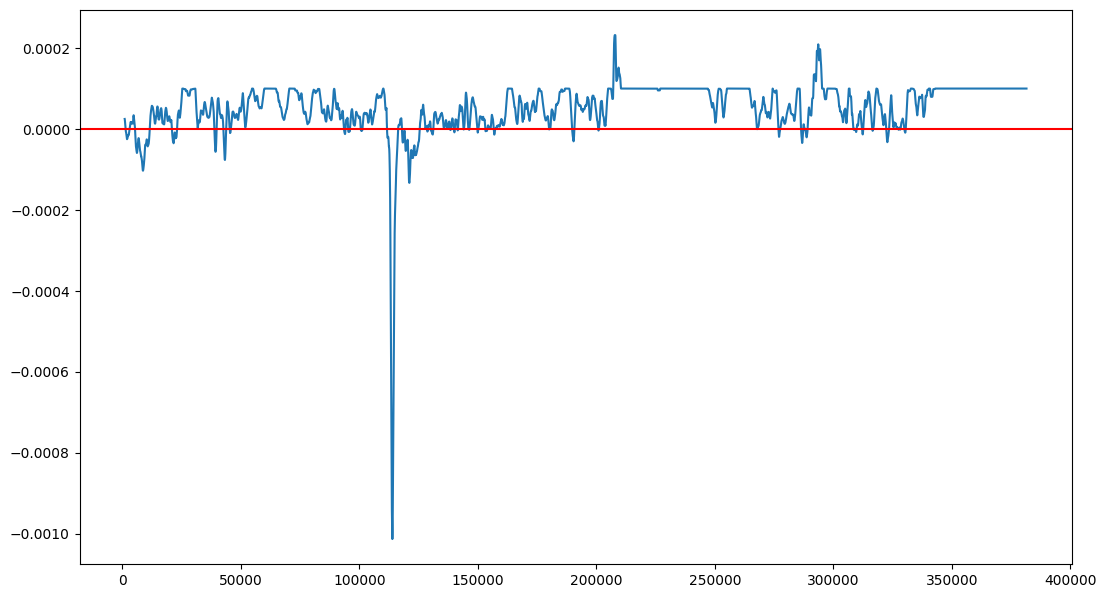

In [53]:
# plt.plot(df_total['funding_rate'])
plt.plot(df_total['funding_rate'].rolling(1000).mean())
plt.axhline(0, c = 'r')

In [54]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


## razmetka

### mark extremums

In [55]:
df_total['diff'] = df_total['open_perp'].diff(1)
df_total['diff_shift1'] = df_total['diff'].shift(-1)
# if price didnt change from t-1, compare with t-2, t-3...
i = -1
print(i, (df_total['diff_shift1'] == 0).sum())
while ((df_total['diff_shift1'] == 0).sum()):
    i -= 1
    df_total.loc[df_total['diff_shift1'] == 0,'diff_shift1'] = \
            df_total['diff'].shift(i)[df_total['diff_shift1'] == 0]
    print(i, (df_total['diff_shift1'] == 0).sum())

df_total['is_extremum'] = (df_total['diff'] * df_total['diff_shift1'] < 0)

-1 8770
-2 1268
-3 401
-4 157
-5 69
-6 34
-7 16
-8 6
-9 2
-10 0


### prep

In [56]:
def plot_selected_extremums(df, column, window=200, color='red', figsize = (20,6)):
    plt.figure(figsize = figsize)
    plt.plot(df.loc[:window, 'open_perp'])
    plt.scatter(df.loc[df['is_extremum'] & (df.index < window)].index, 
                df.loc[df['is_extremum'] & (df.index < window), 'open_perp'], 
                c='yellow')
    plt.scatter(df.loc[df[column] & (df.index < window)].index, 
                df.loc[df[column] & (df.index < window), 'open_perp'], 
                c=color)
    plt.show()
    plt.close()

In [57]:
df_total['ismaxima'] = (df_total['diff_shift1'] < 0) & df_total['is_extremum']
df_total['isminima'] = (df_total['diff_shift1'] >= 0) & df_total['is_extremum']

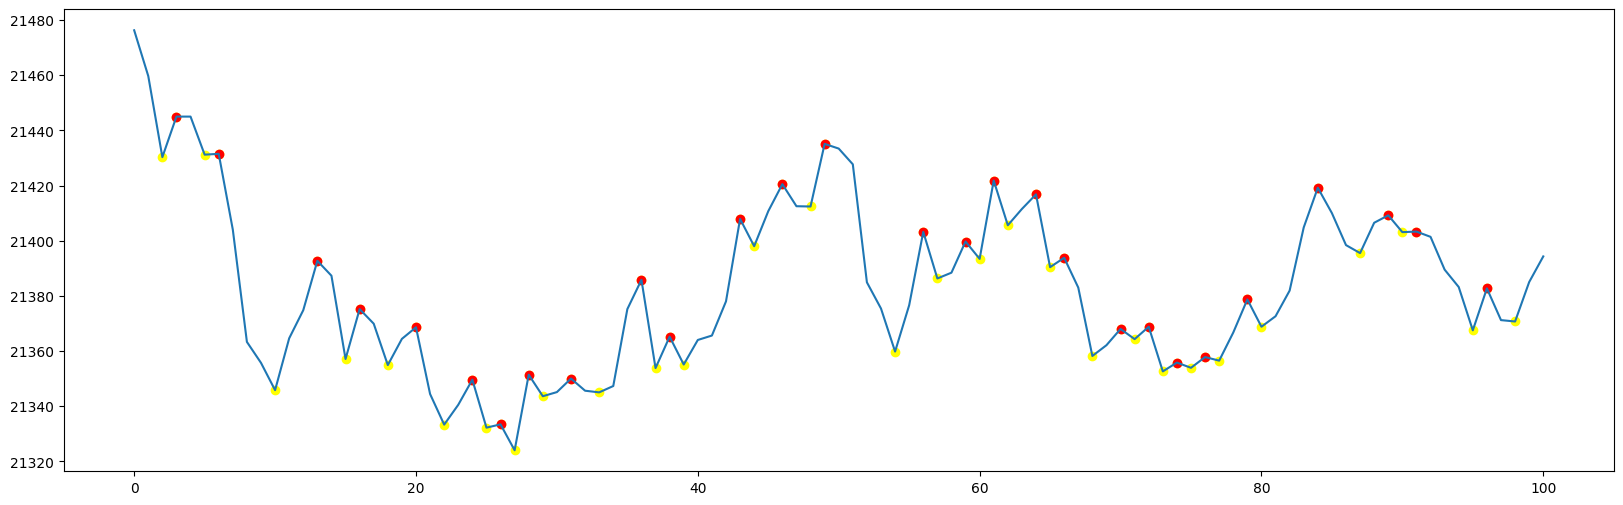

In [58]:
plot_selected_extremums(df_total, 'ismaxima', 100)

In [59]:
df_razmetka = df_total[['timestamp', 'open_perp', 'is_extremum', 'ismaxima', 'isminima']].copy()
df_razmetka.reset_index(inplace=True)
df_razmetka.head()

,index,timestamp,open_perp,is_extremum,ismaxima,isminima
0,0,1661248680,21476.3,False,False,False
1,1,1661248740,21459.7,False,False,False
2,2,1661248800,21430.3,True,False,True
3,3,1661248860,21445.0,True,True,False
4,4,1661248920,21445.0,False,False,False


profit = balance_start * (np.power(1-COMMISSION_RATE, 2) * (1 + LEVERAGE * (1 - close_price/open_price)) - 1)

In [60]:
COMMISSION_RATE = 0.0008
LEVERAGE = 5
balance = 10000

def calculate_profit(balance, open_price, close_price, commision=COMMISSION_RATE, leverage = LEVERAGE):
    return (balance *
            (np.power(1 - commision, 2) *
            (1 + leverage * abs(1 - close_price/open_price))
            - 1))
  
def get_balance(balance, open_price, close_price, commision=COMMISSION_RATE, leverage = LEVERAGE):
    return (balance * 
            (np.power(1 - commision, 2) *
            (1 + leverage * abs(1 - close_price/open_price))))

def get_balance_2contracts(balance, price0, price1, price2):
    balance1 = get_balance(balance, price0, price1)
    balance12 = get_balance(balance1, price1, price2)
    return balance12

def get_balance_3contracts(balance, price0, price1, price2, price3):
        balance1 = get_balance(balance, price0, price1)
        balance12 = get_balance(balance1, price1, price2)
        balance123 = get_balance(balance12, price2, price3)
        return balance123

In [61]:
min_profitability = 1.0075
min_prof_3contracts = min_profitability * 2 - 1

### step1

In [62]:
iterator = iter(df_razmetka.index[df_razmetka['is_extremum']])
#  skip first value because it wouldnt be an extremum
iterator.__next__()
# (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
(index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
extremums = [index_start]
try:
    while True: 
    # for i in range(1000):
        index_first_contract, price_first_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        index_second_contract, price_second_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        index_third_contract, price_third_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]

        balance1 = get_balance(balance, price_start, price_first_contract)
        balance12 = get_balance(balance1, price_first_contract, price_second_contract)
        balance123 = get_balance(balance12, price_second_contract, price_third_contract)
        balance__3 = get_balance(balance, price_start, price_third_contract)


        max_balance = max(balance1, balance123/min_prof_3contracts, balance__3)

        if (max_balance > balance * min_profitability):
            if(max_balance == balance1):    
                extremums.append(index_first_contract)
                price_start = price_first_contract

            elif(max_balance == balance__3):
                iterator = iter(df_razmetka.index[df_razmetka['is_extremum'] & (df_razmetka.index>=index_third_contract)])

            elif(max_balance == balance123/min_prof_3contracts):
                # print(index_first_contract, end=' ')
                extremums.append(index_first_contract)
                iterator = iter(df_razmetka.index[df_razmetka['is_extremum'] & (df_razmetka.index>=index_first_contract)])
                (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        else:
            pass
except StopIteration:
    pass

In [63]:
df_razmetka['extr1'] = np.where(df_razmetka.index.isin(extremums), True, False)

In [64]:
print(f"total extremas: {df_razmetka['is_extremum'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637


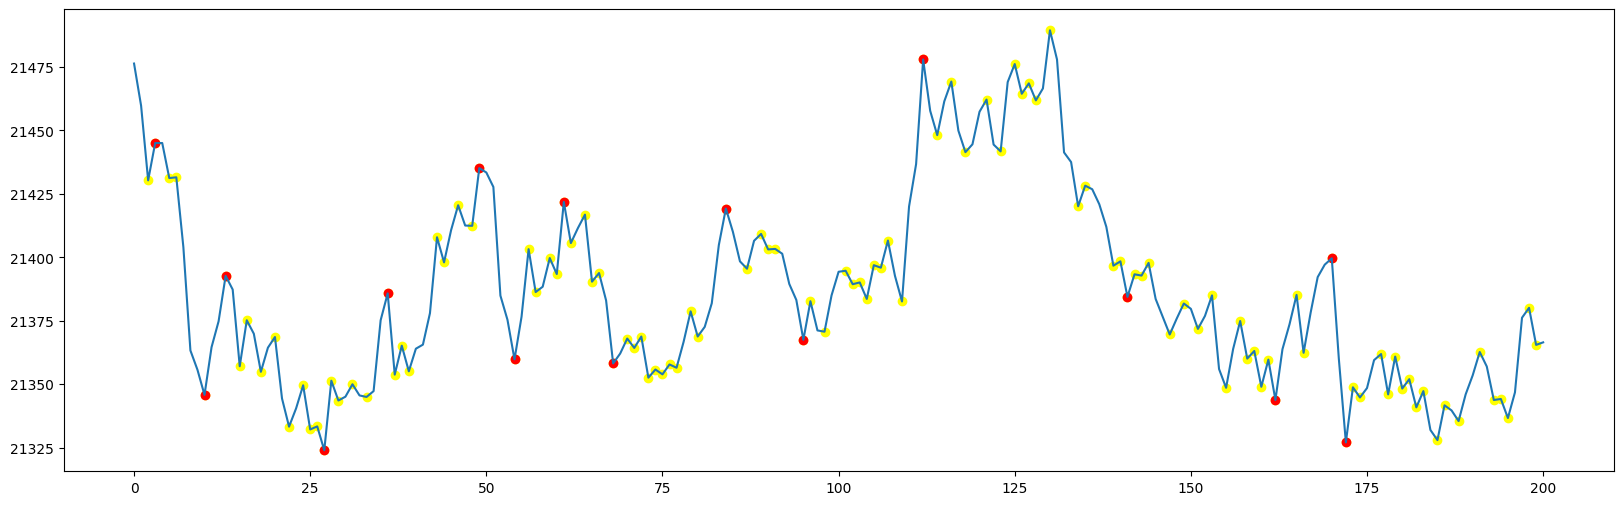

In [65]:
plot_selected_extremums(df_razmetka, 'extr1')

### step2

In [66]:
df_razmetka['extr2'] = df_razmetka['extr1'].copy()

all_extr = df_razmetka.loc[df_razmetka['is_extremum']].copy()
extr2 = df_razmetka.loc[df_razmetka['extr2']].reset_index(drop=True).copy()
non_extr2 = df_razmetka.loc[(~df_razmetka['extr2']) & df_razmetka['is_extremum']].copy()

extr2.head()

,index,timestamp,open_perp,is_extremum,ismaxima,isminima,extr1,extr2
0,3,1661248860,21445.0,True,True,False,True,True
1,10,1661249280,21345.8,True,False,True,True,True
2,13,1661249460,21392.7,True,True,False,True,True
3,27,1661250300,21324.0,True,False,True,True,True
4,36,1661250840,21385.8,True,True,False,True,True


In [67]:
start = 0
try:
    while True:
        left = extr2.loc[start, ['index', 'open_perp']]
        mid = extr2.loc[start+1, ['index', 'open_perp']]
        right = extr2.loc[start+2, ['index', 'open_perp']]
        
        extrema_range = all_extr.loc[left['index']:right['index']]

        if left['open_perp'] > mid['open_perp']:
            index_extrema = extrema_range['open_perp'].idxmin()
        elif left['open_perp'] < mid['open_perp']:
            index_extrema = extrema_range['open_perp'].idxmax()
        else:
            extr2.drop(extr2.index[extr2['index'] == mid['index']])
            continue

        extrema_range = all_extr.loc[left['index']:right['index']]
        if index_extrema == mid['index']:
            start += 1
            continue
        elif index_extrema == right['index']:
            extr2 = extr2.drop(start+1).reset_index(drop=True)
            continue
        else:
            # print(f"replace extrema {mid['index']} on {index_extrema}")
            extr2.loc[start+1] = extrema_range.loc[index_extrema]
            start += 1
            continue
except:
    pass

In [68]:
df_razmetka['extr2'] = np.where(df_razmetka.index.isin(extr2['index']), True, False)

In [70]:
print(f"total extremas: {df_razmetka['is_extremum'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040


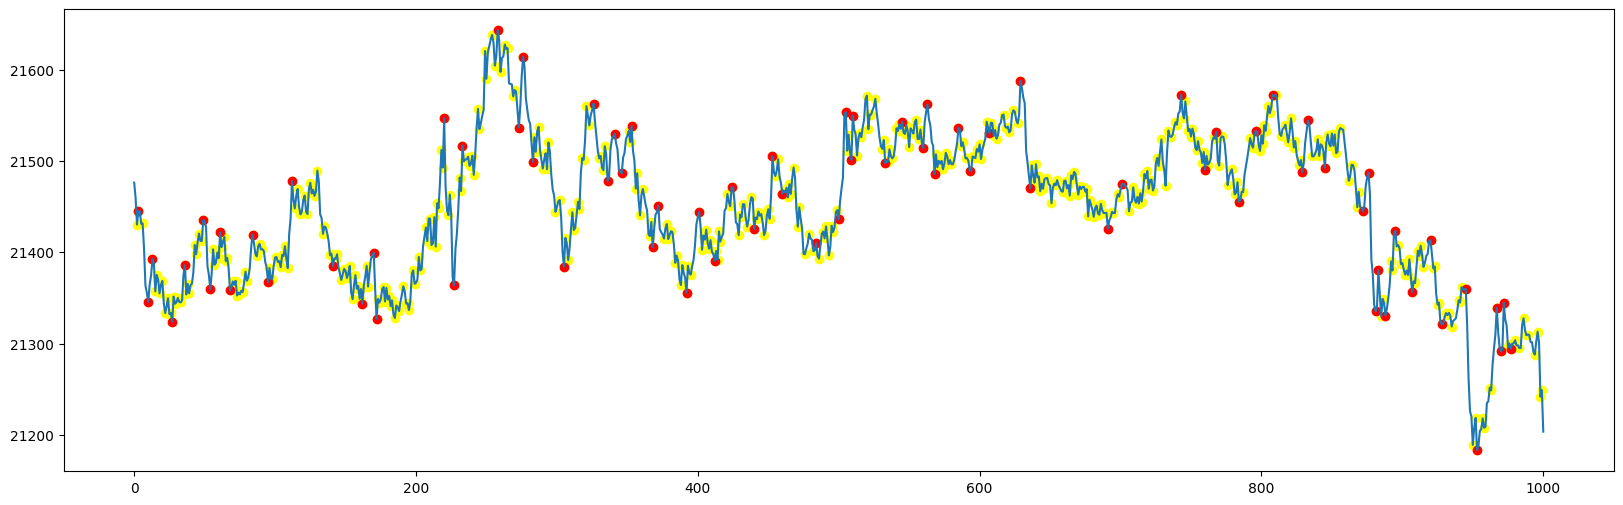

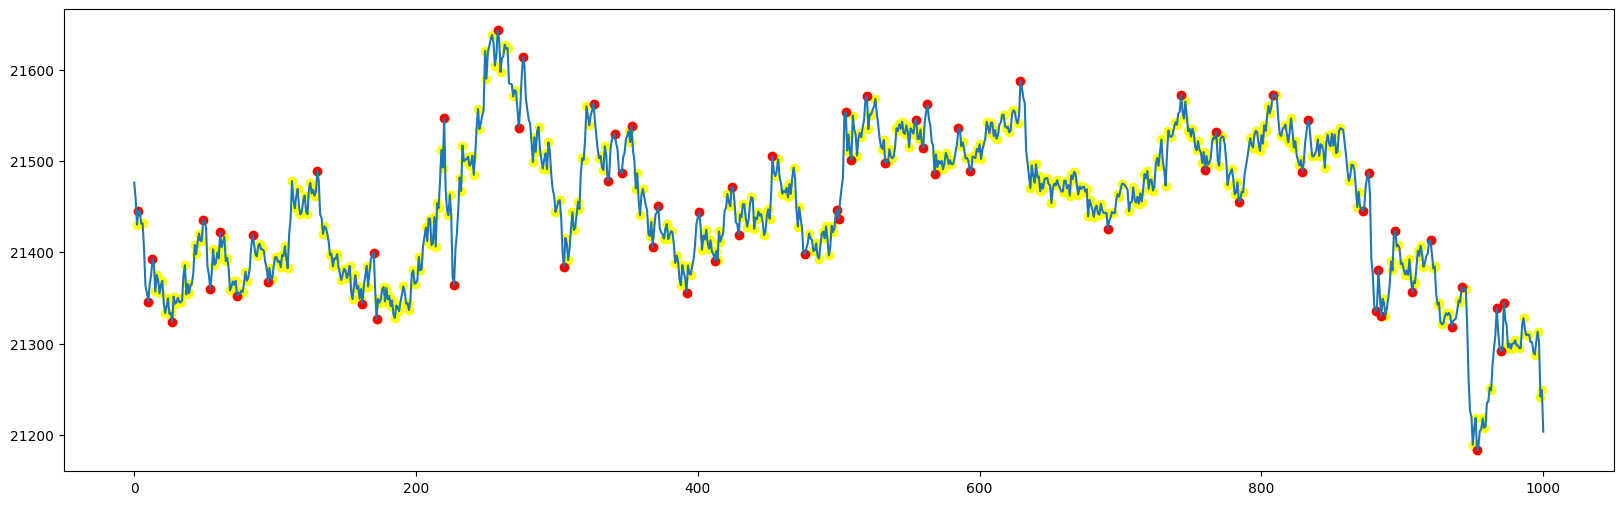

In [74]:
plot_selected_extremums(df_razmetka, 'extr1', 1000)
plot_selected_extremums(df_razmetka, 'extr2', 1000)

### step 3

In [75]:
df_razmetka.loc[df_razmetka['extr2']].head()

,index,timestamp,open_perp,is_extremum,ismaxima,isminima,extr1,extr2
3,3,1661248860,21445.0,True,True,False,True,True
10,10,1661249280,21345.8,True,False,True,True,True
13,13,1661249460,21392.7,True,True,False,True,True
27,27,1661250300,21324.0,True,False,True,True,True
49,49,1661251620,21435.1,True,True,False,True,True


In [78]:
def price(idx):
    return df_razmetka.loc[idx, 'open_perp']
    
    
extremas_todrop = []
for contract0, contract1, contract2, contract3 in zip(
                        df_razmetka.loc[df_razmetka['extr2'], 'index'].iloc[:-3], 
                        df_razmetka.loc[df_razmetka['extr2'], 'index'].shift(-1).iloc[:-3], 
                        df_razmetka.loc[df_razmetka['extr2'], 'index'].shift(-2).iloc[:-3], 
                        df_razmetka.loc[df_razmetka['extr2'], 'index'].shift(-3).iloc[:-3]):
    # print(contract0, contract1, contract2, contract3)
    # print(price(contract0), price(contract1), price(contract2), price(contract3))

    balance1 = get_balance(1, 
                price(contract0), 
                price(contract3))
    balance3 = get_balance_3contracts(1, 
                price(contract0), 
                price(contract1), 
                price(contract2), 
                price(contract3))
    if (balance1 >= balance3*min_prof_3contracts):
        extremas_todrop += [contract1, contract2]
        print(extremas_todrop)

    

In [80]:
df_razmetka.loc[df_razmetka['extr2']].head()

,index,timestamp,open_perp,is_extremum,ismaxima,isminima,extr1,extr2
3,3,1661248860,21445.0,True,True,False,True,True
10,10,1661249280,21345.8,True,False,True,True,True
13,13,1661249460,21392.7,True,True,False,True,True
27,27,1661250300,21324.0,True,False,True,True,True
49,49,1661251620,21435.1,True,True,False,True,True


### step 4

In [81]:
from tqdm import tqdm

In [82]:
# def step3():
#     new_extremums3 = []
#     for start, end in tqdm(zip(df_razmetka.loc[df_razmetka['extr3'], 'index'].iloc[:-1], df_razmetka.loc[df_razmetka['extr3'], 'index'].shift(-1))):
#         # print(df_razmetka.loc[start+1:end-1].loc[df_razmetka['isminima']].index)
#         # print(df_razmetka.loc[start+1:end-1].loc[df_razmetka['ismaxima']].index)

#         if (df_razmetka.loc[start, 'open_perp'] > df_razmetka.loc[end, 'open_perp']):
#             order_short_long = ('isminima', 'ismaxima')
#         elif (df_razmetka.loc[start, 'open_perp'] > df_razmetka.loc[end, 'open_perp']):
#             order_short_long = ('ismaxima', 'isminima')

#         profitable_combos = {}
#         for first_contract in df_razmetka.loc[start+1:end-1].loc[df_razmetka[order_short_long[0]]].index:
#             for second_contract in df_razmetka.loc[first_contract+1:end-1].loc[df_razmetka[order_short_long[1]]].index:
#                 # print(first_contract, second_contract)
#                 extr2_balance = get_balance(1, df_razmetka.loc[start, 'open_perp'], df_razmetka.loc[end, 'open_perp'])

#                 extr3_1 = get_balance(1, df_razmetka.loc[start, 'open_perp'], df_razmetka.loc[first_contract, 'open_perp'])
#                 extr3_2 = get_balance(extr3_1, df_razmetka.loc[first_contract, 'open_perp'], df_razmetka.loc[second_contract, 'open_perp'])
#                 extr3_balance = get_balance(extr3_2, df_razmetka.loc[second_contract, 'open_perp'], df_razmetka.loc[end, 'open_perp'])

#                 if(extr3_balance > extr2_balance * min_prof_3contracts):
#                     profitable_combos.update({(first_contract, second_contract) : extr3_balance})
#         if(len(profitable_combos) > 0):
#             new_extremums3.append(max(profitable_combos, key=profitable_combos.get))
#             # print('interval: ',start, end)
#             # print(profitable_combos)
#             # print('best: ',max(profitable_combos, key=profitable_combos.get))
#             # print()
#     return(new_extremums3)

In [83]:
def step3(df_raw, existing_extrema_col):
    df = df_raw.copy()
    df['extr3'] = df[existing_extrema_col]
    while(True):
        new_extremums3 = []
        for start, end in tqdm(zip(df.loc[df['extr3'], 'index'].iloc[:-1], df.loc[df['extr3'], 'index'].shift(-1))):
            if (df.loc[start, 'open_perp'] > df.loc[end, 'open_perp']):
                order_short_long = ('isminima', 'ismaxima')
            elif (df.loc[start, 'open_perp'] > df.loc[end, 'open_perp']):
                order_short_long = ('ismaxima', 'isminima')

            profitable_combos = {}
            for first_contract in df.loc[start+1:end-1].loc[df[order_short_long[0]]].index:
                for second_contract in df.loc[first_contract+1:end-1].loc[df[order_short_long[1]]].index:
                    extr2_balance = get_balance(1, 
                                                df.loc[start, 'open_perp'], 
                                                df.loc[end, 'open_perp'])
                    extr3_balance = get_balance_3contracts(1, 
                                                df.loc[start, 'open_perp'],
                                                df.loc[first_contract, 'open_perp'],
                                                df.loc[second_contract, 'open_perp'],
                                                df.loc[end, 'open_perp'])
                    
                    if(extr3_balance > extr2_balance * min_prof_3contracts):
                        profitable_combos.update({(first_contract, second_contract) : extr3_balance})
            if(len(profitable_combos) > 0):
                new_extremums3.append(max(profitable_combos, key=profitable_combos.get))
        print(f"extremas before: {df['extr3'].sum()}")
        df.loc[pd.Series(new_extremums3).explode().values, 'extr3'] = True
        print(f"extremas after: {df['extr3'].sum()}")
        
        if (len(new_extremums3) == 0):
            return df

In [78]:
df_razmetka = step3(df_razmetka, 'extr2')

16039it [02:26, 109.60it/s]


extremas before: 16040
extremas after: 17430


17429it [01:58, 146.80it/s]


extremas before: 17430
extremas after: 17688


17687it [01:54, 153.92it/s]


extremas before: 17688
extremas after: 17714


17713it [01:55, 153.67it/s]


extremas before: 17714
extremas after: 17716


17715it [01:55, 153.64it/s]

extremas before: 17716
extremas after: 17716


In [83]:
print(f"total extremas: {df_razmetka['is_extremum'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")
print(f"extremas after step3: {df_razmetka['extr3'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040
extremas after step3: 17,716


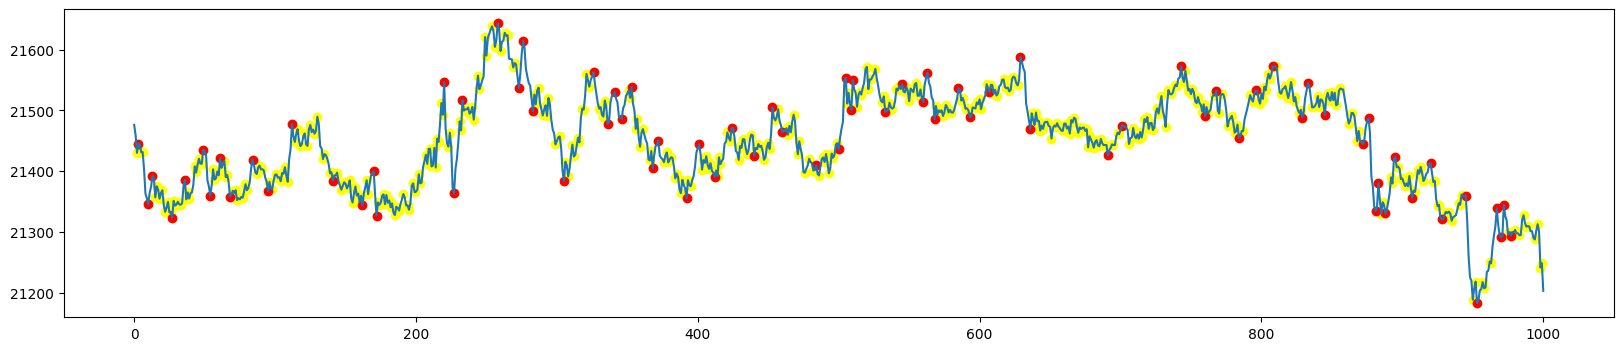

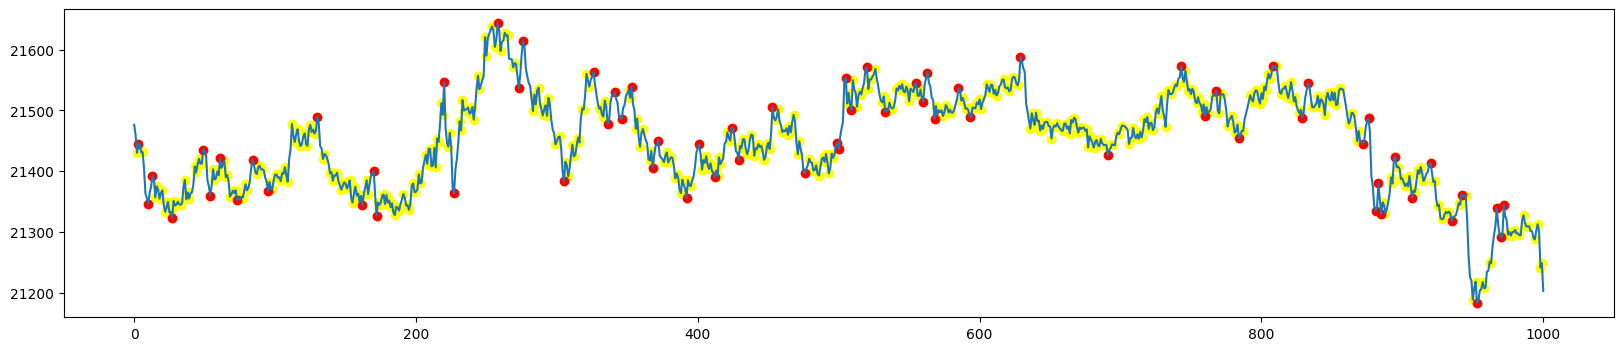

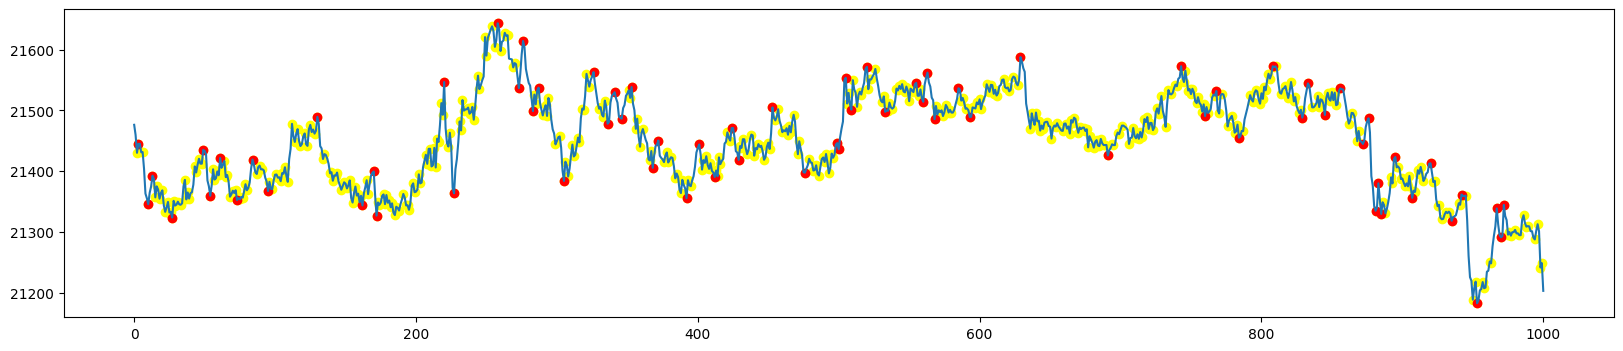

In [85]:
plot_selected_extremums(df_razmetka, 'extr1', 1000, figsize=(20,4))
plot_selected_extremums(df_razmetka, 'extr2', 1000, figsize=(20,4))
plot_selected_extremums(df_razmetka, 'extr3', 1000, figsize=(20,4))

## punish 30min+

In [63]:
df_razmetka.loc[df_razmetka['extr2'], 'timestamp'].diff().quantile(0.885)

3000.0

In [64]:
df_razmetka.loc[df_razmetka['extr2']].head()

,index,timestamp,open_perp,is_extremum,ismaxima,isminima,extr1,extr2
3,3,1661248860,21445.0,True,True,False,True,True
10,10,1661249280,21345.8,True,False,True,True,True
13,13,1661249460,21392.7,True,True,False,True,True
27,27,1661250300,21324.0,True,False,True,True,True
49,49,1661251620,21435.1,True,True,False,True,True


In [65]:
extremums = df_razmetka.loc[df_razmetka['extr2']].copy()

In [66]:
extremums['diff'] = extremums['timestamp'].diff() 

In [67]:
extremums.head()

,index,timestamp,open_perp,is_extremum,ismaxima,isminima,extr1,extr2,diff
3,3,1661248860,21445.0,True,True,False,True,True,NaN
10,10,1661249280,21345.8,True,False,True,True,True,420.0
13,13,1661249460,21392.7,True,True,False,True,True,180.0
27,27,1661250300,21324.0,True,False,True,True,True,840.0
49,49,1661251620,21435.1,True,True,False,True,True,1320.0


In [68]:
extremums.loc[extremums['diff'] > 3000]

,index,timestamp,open_perp,is_extremum,ismaxima,isminima,extr1,extr2,diff
691,691,1661290140,21425.9,True,False,True,True,True,3720.0
743,743,1661293260,21572.5,True,True,False,True,True,3120.0
1177,1177,1661319300,21478.4,True,True,False,True,True,8460.0
1812,1812,1661357400,21909.3,True,True,False,True,True,3960.0
2114,2114,1661375520,21655.0,True,False,True,True,True,3180.0
...,...,...,...,...,...,...,...,...,...
380595,380595,1684084380,26879.9,True,False,True,False,True,3780.0
380832,380832,1684098600,26943.2,True,True,False,True,True,6120.0
380883,380883,1684101660,26861.1,True,False,True,False,True,3060.0
381007,381007,1684109100,26917.6,True,True,False,False,True,3240.0


In [69]:
(df_razmetka.loc[df_razmetka['extr2'], 'timestamp'].diff() > 3000).value_counts()

False    14205
True      1835
Name: timestamp, dtype: int64

In [70]:
60 * 30

1800

## Initial model

### final df prep

In [71]:
df_total.to_csv('data/df_total.csv')
df_razmetka.to_csv('data/df_razmetka.csv')

df_total = pd.read_csv('data/df_total.csv', index_col=[0])
df_razmetka = pd.read_csv('data/df_razmetka.csv', index_col=[0])

In [ ]:
df_fin = df_total.copy()

In [ ]:
df_fin['extr2'] = df_razmetka['extr2']

In [ ]:
df_fin.drop(columns=['symbol_perp','time_diff', 'diff', 'diff_shift1', 'is_extremum'], inplace=True)

In [ ]:
df_fin.head()

,timestamp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left,ismaxima,isminima,extr2
0,1661248680,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120,False,False,False
1,1661248740,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060,False,False,False
2,1661248800,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000,False,True,False
3,1661248860,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940,True,False,True
4,1661248920,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880,False,False,False


In [ ]:
df_fin.groupby('symbol_cq').agg({'timestamp':['min', 'max']}).apply(lambda x: pd.to_datetime(x, unit='s'))

timestamp                    
                               min                 max
symbol_cq                                             
BTCUSDT_220930 2022-08-23 09:58:00 2022-09-30 08:00:00
BTCUSDT_221230 2022-09-30 08:01:00 2022-12-30 08:00:00
BTCUSDT_230331 2022-12-30 08:01:00 2023-03-31 08:00:00
BTCUSDT_230630 2023-03-31 08:01:00 2023-05-15 08:16:00

Lets imagine our range of opening contract lays between 

(high + max(open, close))/2

and

(low + min(open, close))/2

In [ ]:
df_fin['low_border'] = (df_fin['low_perp'] + df_fin[['open_perp', 'close_perp']].min(axis=1)) / 2
df_fin['up_border'] = (df_fin['high_perp'] + df_fin[['open_perp', 'close_perp']].max(axis=1)) / 2

In [ ]:
df_fin.head()

,timestamp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left,ismaxima,isminima,extr2,low_border,up_border
0,1661248680,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120,False,False,False,21455.3,21478.05
1,1661248740,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060,False,False,False,21430.2,21459.70
2,1661248800,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000,False,True,False,21422.2,21445.00
3,1661248860,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940,True,False,True,21437.5,21445.90
4,1661248920,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880,False,False,False,21430.6,21446.80


In [ ]:
df_fin.loc[df_fin['extr2'] & df_fin['ismaxima'], 'target'] = df_fin.loc[df_fin['extr2'] & df_fin['ismaxima'], 'up_border']
df_fin.loc[df_fin['extr2'] & df_fin['isminima'], 'target'] = df_fin.loc[df_fin['extr2'] & df_fin['isminima'], 'low_border']

In [ ]:
df_fin = df_fin.fillna(method='bfill').dropna()

In [ ]:
df_fin.head()

,timestamp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left,ismaxima,isminima,extr2,low_border,up_border,target
0,1661248680,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120,False,False,False,21455.3,21478.05,21445.9
1,1661248740,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060,False,False,False,21430.2,21459.70,21445.9
2,1661248800,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000,False,True,False,21422.2,21445.00,21445.9
3,1661248860,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940,True,False,True,21437.5,21445.90,21445.9
4,1661248920,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880,False,False,False,21430.6,21446.80,21344.8


In [ ]:
X = df_fin.drop(columns= ['timestamp', 'symbol_cq', 'ismaxima', 'isminima', 'extr2', 'low_border', 'up_border', 'target'])
y = df_fin['target']

In [86]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y.values.reshape(-1,1))

In [88]:
X_scaled
y_scaled

array([[-0.06290122],
       [-0.06290122],
       [-0.06290122],
       ...,
       [ 1.35983338],
       [ 1.35983338],
       [ 1.35983338]])

## Simple Keras LSTM model

## Archive

In [ ]:
# # for left, mid, right in zip(new_extremums[:-2], new_extremums[1:-1], new_extremums[2:]):
# non_extremums = pd.Series(list(set(df_total.index[df_total['is_extremum']]) - set(extremums) - set([2])))
# non_extremums.head()

# new_extremums = extremums.copy()
# start = 0
# while True:
#     new_extremums.reset_index(inplace=True, drop=True)
#     # print(new_extremums.head())
#     left, mid, right = new_extremums.index[start], new_extremums.index[start+1], new_extremums.index[start+2]
#     print(f"{start} - {new_extremums[left]:>3} ({df_total.loc[left, 'open_perp']}) {new_extremums[mid]} ({df_total.loc[mid, 'open_perp']}) {new_extremums[right]} ({df_total.loc[right, 'open_perp']})", end = '   ')
#     points_inbetween = non_extremums[(non_extremums > left) & (non_extremums < right)]
#     all_points = pd.concat([points_inbetween, pd.Series([left, mid, right])])
#     if (df_total.loc[new_extremums[left], 'open_perp'] > df_total.loc[new_extremums[mid], 'open_perp']):
#         print('min')
#         new_minima = df_total.loc[all_points, 'open_perp'].idxmin()
#         if new_minima == new_extremums[mid]:
#             start += 1
#             continue
#         elif new_minima == new_extremums[right]:
#             new_extremums.pop(new_extremums[start+1])
#             continue
#         else:
#             new_extremums[start+1] = new_minima
#             start += 1
#             continue
#     elif (df_total.loc[new_extremums[left], 'open_perp'] < df_total.loc[new_extremums[mid], 'open_perp']):
#         print('max')
#         new_maxima = df_total.loc[all_points, 'open_perp'].idxmax()
#         if new_maxima == new_extremums[mid]:
#             start += 1
#             continue
#         elif new_maxima == new_extremums[right]:
#             new_extremums.pop(new_extremums[start+1])
#             continue
#         else:
#             new_extremums[start+1] = new_maxima
#             start += 1
#             continue
#     else:
#         print('drop')
#         new_extremums.pop(new_extremums.index[mid])
#         continue
    
        

0 -   3 (21476.3) 10 (21459.7) 13 (21430.3)   min
1 -   2 (21459.7) 13 (21430.3) 26 (21445.0)   min
2 -   2 (21430.3) 26 (21445.0) 35 (21445.0)   min
3 -   2 (21445.0) 35 (21445.0) 48 (21431.2)   min
4 -   5 (21445.0) 48 (21431.2) 53 (21431.5)   max
5 -   4 (21431.2) 53 (21431.5) 60 (21404.0)   min
6 -   7 (21431.5) 60 (21404.0) 67 (21363.3)   max
7 -   6 (21404.0) 67 (21363.3) 83 (21355.7)   min
8 -   9 (21363.3) 83 (21355.7) 94 (21345.8)   max
9 -   8 (21355.7) 94 (21345.8) 111 (21364.6)   max
10 -  11 (21345.8) 111 (21364.6) 140 (21374.8)   max
11 -  12 (21364.6) 140 (21374.8) 161 (21392.7)   max
12 -  13 (21374.8) 161 (21392.7) 169 (21387.3)   min
13 -  12 (21392.7) 169 (21387.3) 171 (21357.1)   max
14 -  13 (21387.3) 171 (21357.1) 219 (21375.2)   min
15 -  15 (21357.1) 219 (21375.2) 226 (21354.9)   max
16 -  16 (21375.2) 226 (21354.9) 232 (21364.4)   min
17 -  17 (21354.9) 232 (21364.4) 257 (21368.6)   max
18 -  19 (21364.4) 257 (21368.6) 272 (21344.4)   max
19 -  19 (21368.6) 272

IndexError: index 36 is out of bounds for axis 0 with size 36